In [2]:
import sqlite3
con = sqlite3.connect("Sample-Superstore.db")
cur = con.cursor()

import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
import statistics
import datetime
import calendar


In [3]:
df = pd.read_csv("Sample-Superstore - Sample-Superstore.tsv", delimiter = '\t')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:


for col in df:
    df.rename(columns={col: col.lower().replace(' ', '').replace('-', '')}, inplace=True)



In [5]:
# Select relevant columns for each table
orders_ = ['orderid', 'orderdate', 'shipdate', 'shipmode', 'customerid', 'productid']
customers_ = ['customerid', 'customername', 'segment']
addresses_ = ['customerid', 'country', 'city', 'state', 'postalcode', 'region']
products_ = ['productid', 'category', 'subcategory', 'productname']
sales_ = ['sales', 'orderid', 'quantity', 'productid', 'discount', 'profit']


In [6]:
# Create new dataframes for each table
orders = df.loc[:, orders_].drop_duplicates(subset='orderid', keep='first').reset_index(drop=True)
customers = df.loc[:, customers_].drop_duplicates(subset='customerid', keep='first').reset_index(drop=True)
addresses = df.loc[:, addresses_].drop_duplicates(subset='customerid', keep='first').reset_index(drop=True)
products = df.loc[:, products_].drop_duplicates(subset='productid', keep='first').reset_index(drop=True)
sales = df.loc[:, sales_].reset_index(drop=True)

In [7]:
cur.execute("DROP TABLE IF EXISTS Customers")
cur.execute("DROP TABLE IF EXISTS Addresses")
cur.execute("DROP TABLE IF EXISTS Orders")
cur.execute("DROP TABLE IF EXISTS Products")
cur.execute("DROP TABLE IF EXISTS Sales")

In [8]:
cur.executescript("""
CREATE TABLE Customers (
  customerid TEXT PRIMARY KEY,
  customername TEXT,
  segment TEXT
);
""")

cur.execute("""
CREATE TABLE Orders (
  orderid TEXT PRIMARY KEY,
  orderdate TEXT,
  shipdate TEXT,
  shipmode TEXT,
  customerid TEXT,
  productid TEXT,
  FOREIGN KEY (customerid) REFERENCES Customer (customerid)
);
""")

cur.execute("""
CREATE TABLE Products (
  productid TEXT PRIMARY KEY,
  category TEXT,
  subcategory TEXT,
  productname TEXT
);
""")

cur.execute("""
CREATE TABLE Sales (
  orderid TEXT,
  productid TEXT,
  sales FLOAT64,
  quantity INTEGER,
  discount FLOAT64,
  profit FLOAT64,
  FOREIGN KEY (orderid) REFERENCES Orders (orderid)
  FOREIGN KEY (productid) REFERENCES "Products" (productid)
);
""")

cur.execute("""
CREATE TABLE Addresses (
  customerid TEXT PRIMARY KEY,
  country TEXT,
  city TEXT,
  state TEXT,
  postalcode INTEGER,
  region TEXT,
  FOREIGN KEY (customerid) REFERENCES Customer (customerid)
);
""")

con.commit()

In [9]:
orders.info()
customers.info()
addresses.info()
products.info()
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   orderid     5009 non-null   object
 1   orderdate   5009 non-null   object
 2   shipdate    5009 non-null   object
 3   shipmode    5009 non-null   object
 4   customerid  5009 non-null   object
 5   productid   5009 non-null   object
dtypes: object(6)
memory usage: 234.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customerid    793 non-null    object
 1   customername  793 non-null    object
 2   segment       793 non-null    object
dtypes: object(3)
memory usage: 18.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  

In [10]:
sales.head()

,sales,orderid,quantity,productid,discount,profit
0,261.9600,CA-2016-152156,2,FUR-BO-10001798,0.00,41.9136
1,731.9400,CA-2016-152156,3,FUR-CH-10000454,0.00,219.5820
2,14.6200,CA-2016-138688,2,OFF-LA-10000240,0.00,6.8714
3,957.5775,US-2015-108966,5,FUR-TA-10000577,0.45,-383.0310
4,22.3680,US-2015-108966,2,OFF-ST-10000760,0.20,2.5164


In [11]:
orders.to_sql('Orders', con, if_exists='append', index=False)
customers.to_sql('Customers', con, if_exists='append', index=False)
addresses.to_sql('Addresses', con, if_exists='append', index=False)
products.to_sql('Products', con, if_exists='append', index=False)
sales.to_sql('Sales', con, if_exists='append', index=False)

9994

In [12]:
def run(cmd):
    r = cur.execute(cmd)
    display(r.fetchall())

Queries

What is the category generating the maximum sales revenue?

In [13]:
run("""
SELECT category, SUM(sales)
FROM Sales
LEFT JOIN Products ON Sales.productid = Products.productid
GROUP BY Products.category
ORDER BY SUM(sales) DESC LIMIT 1
;""")

[('Technology', 836154.0329999966)]

What about the profit in this category?

In [14]:
run("""
SELECT Products.category, SUM(profit)
FROM Sales
LEFT JOIN Products ON Sales.productid = Products.productid
GROUP BY Products.category
ORDER BY SUM(sales) DESC LIMIT 1
;""")

[('Technology', 145454.9480999999)]

EDA

In [15]:
df.dtypes

rowid             int64
orderid          object
orderdate        object
shipdate         object
shipmode         object
customerid       object
customername     object
segment          object
country          object
city             object
state            object
postalcode        int64
region           object
productid        object
category         object
subcategory      object
productname      object
sales           float64
quantity          int64
discount        float64
profit          float64
dtype: object

In [16]:
df.shape
df.isna()

,rowid,orderid,orderdate,shipdate,shipmode,customerid,customername,segment,country,city,...,postalcode,region,productid,category,subcategory,productname,sales,quantity,discount,profit
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9990,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9992,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
df.head(5)

,rowid,orderid,orderdate,shipdate,shipmode,customerid,customername,segment,country,city,...,postalcode,region,productid,category,subcategory,productname,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [18]:
df.tail(5)

,rowid,orderid,orderdate,shipdate,shipmode,customerid,customername,segment,country,city,...,postalcode,region,productid,category,subcategory,productname,sales,quantity,discount,profit
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.248,3,0.2,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.576,2,0.2,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200
9993,9994,CA-2017-119914,5/4/2017,5/9/2017,Second Class,CC-12220,Chris Cortes,Consumer,United States,Westminster,...,92683,West,OFF-AP-10002684,Office Supplies,Appliances,"Acco 7-Outlet Masterpiece Power Center, Wihtou...",243.160,2,0.0,72.9480


In [19]:
df.isnull().sum()

rowid           0
orderid         0
orderdate       0
shipdate        0
shipmode        0
customerid      0
customername    0
segment         0
country         0
city            0
state           0
postalcode      0
region          0
productid       0
category        0
subcategory     0
productname     0
sales           0
quantity        0
discount        0
profit          0
dtype: int64

Category Count

Text(0.5, 1.0, 'Category Count')

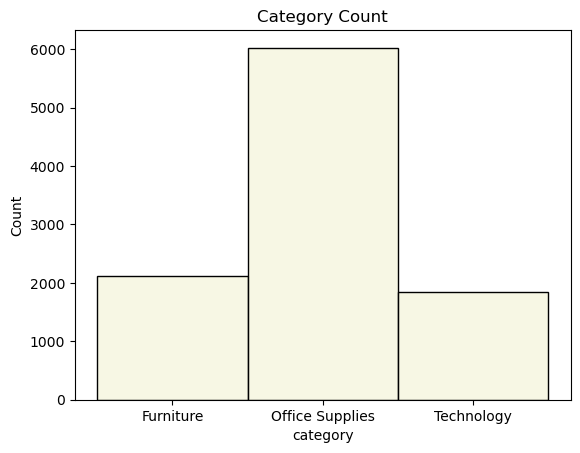

In [20]:
sns.histplot(data=df, x= "category", color= 'beige').set_title('Category Count')


Subcategory Count

Text(0.5, 1.0, 'Subcategory Count')

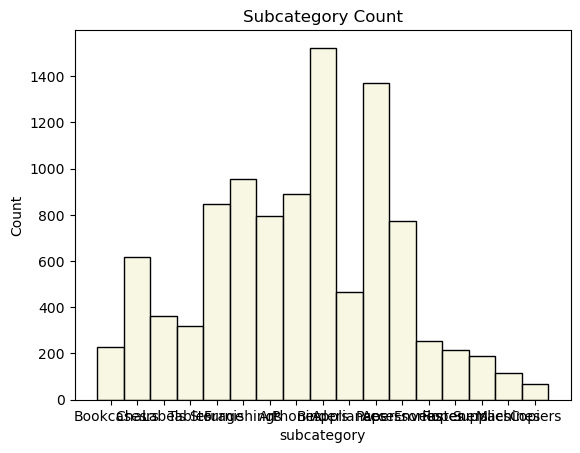

In [21]:
sns.histplot(data=df, x= "subcategory", color= 'beige').set_title('Subcategory Count')


Sales

Text(0.5, 1.0, 'Segment')

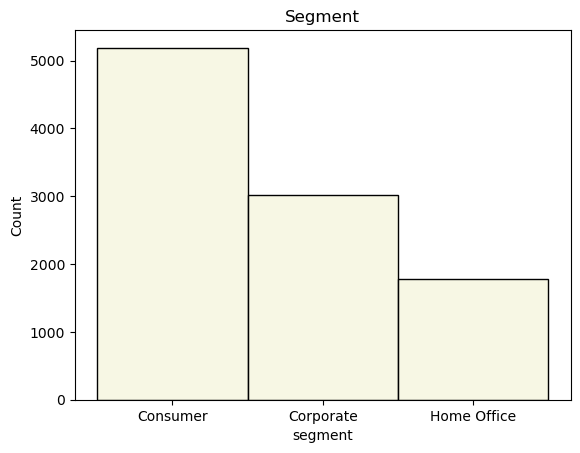

In [22]:
sns.histplot(data=df, x= "segment", color= 'beige').set_title('Segment')


Region

Text(0.5, 1.0, 'Region')

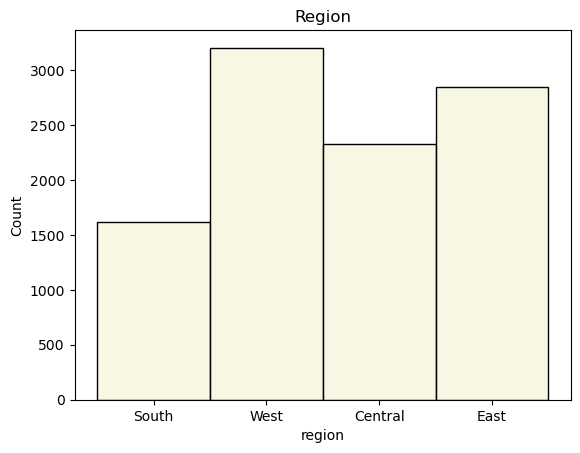

In [23]:
sns.histplot(data=df, x= "region", color= 'beige').set_title('Region')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

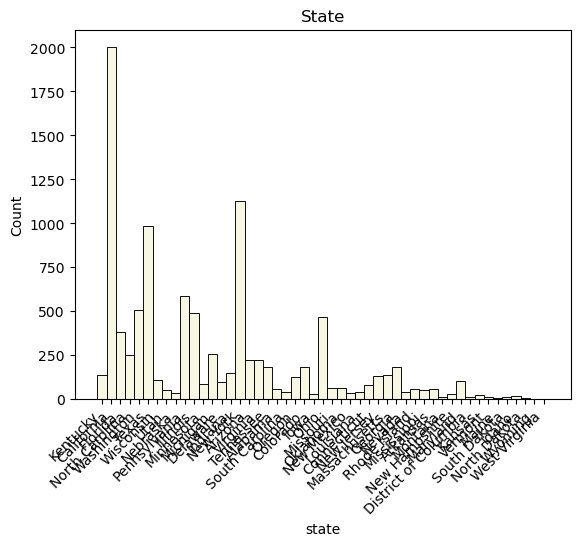

In [25]:
chart = sns.histplot(data=df, x= "state", color= 'beige').set_title('State')
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, horizontalalignment='right')

In [ ]:
sns.lineplot(x = "month", y = "count", data= day).set_title('Monthly Count')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

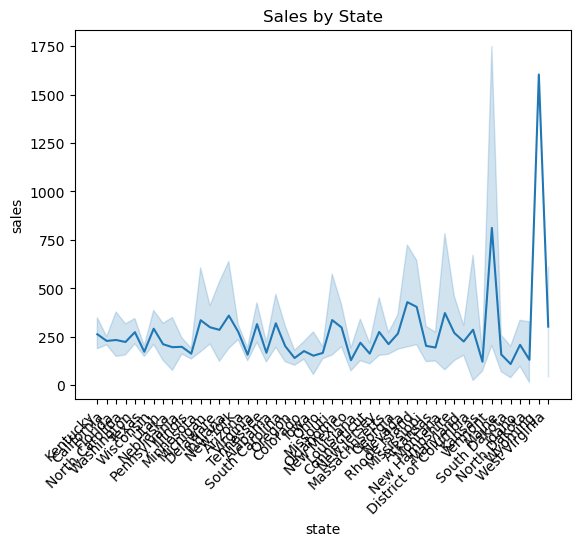

In [27]:
sns.lineplot(x = "state", y = "sales", data= df).set_title('Sales by State')
plt.xticks(rotation=45, horizontalalignment='right')
